## Data Science Nanodegree Spring 2025
## Project 2-6 by Mitchell Steffen 

# Identify and predict patterns in migration of ancestors by time period and country. 


## Learning objective / Business Understanding
Our ethinic identity is normally defined by a specific country or region our ancestors came from.  However, for many people their ancestors came from multiple countries and regions as peoples migrated and intermarried.  This is reflected in DNA tests which list multiple countries of origin for specfic gene traits.  But what was the path that lead from these countries of origin to who I am today?  That path is recorded in our family history, the genealogy of the line of ancestors going from us to these countries of origin.  Unlike DNA tests, our genealogy doesn't come with a one-page summary of all the steps from the past to the present.   

While most ancestors lived in the same location all their lives, at certain periods in history in certain countries family groups or individuals would move to a new country.  Visualizing the times and places of these major changes in ancestors lives can give insight into the life experiences that shaped their lives and lead to the places and times we now live in.  Genealogy records of life events such as birth and death dates and locations give the raw data for identifying these inflection points in our family's path.  However, this genealogy data is not in a consistent standard format, locations have changed names over the years and boundaries of countries have shifted, and many records give only dates but lack location.  

This project makes a first step in filling out the gaps in ancestor records by modeling the patterns of which time periods and which locations were more likely to have movement from ancestral homelands.  Specific business questions addressed include:
- Which countries were the home location ancestors originated from?
- Which countries had the highest numbers of ancestors who migrated to other countries?
- Which time periods had the highest numbers of ancestors who migrated to other countries?

    
## Data Sources / Data Understanding
Family history compiled, cleaned, labeled, merged, and analyzed from multiple sources from 2009 - 2024, and summarized in:  
https://github.com/mtmssteffen/WhoAreWe
 - `Ancestor_data.csv`:  Genealogy of ancestors, uniquely ID each individual, giving family surname, gendter, birth & death year & location, IDs of parents, and an intepretation of the country of origin.
 - `FamilyAtlasPlacesGeocode.csv`:  List of raw locations from Ancestor_data run through the Family Atlas geocoding tool to generate standard location names and latitute-longitude.  About half of the raw locations had automated matches, and close matches required manual review and updating.
- `DSN-Project-2-6.ipynb`: Jupyter notebook with the complete CRISP-DM process including Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, Deployment
- `amap.mp4`:  Animation of Estimated Country data from the Ancestor_data.csv file for comparison with the analysis and models created by this project.
    

### Ancestor Relationships Representation for Modeling

![Lineage Graph](https://github.com/user-attachments/assets/48271115-551d-43fc-9bbc-39f20584f3af)

    

## Exploratory Data Analysis / Data Preparation



In [2]:
import pandas as pd
import numpy as np
import os
import random
import re
import string
from datetime import datetime as dt
import datetime
import time
import sys
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

# imports from stats models for OLS with p-values 
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as smf_metrics
import statsmodels.api as sm

from scipy import stats

#imports from scikit learn for metrics 
from sklearn import feature_selection, linear_model, metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm


In [238]:
ad_df = pd.read_csv('Ancestor_data.csv')
ad_df.head()

,INDI_ID,Surname,Sex,BirthYear,BirthPlace,DeathYear,DeathPlace,Father_ID,Mother_ID,FAMS_ID1,Spouse_ID,FromChild,EstCountry
0,I10,Steffen,M,1890.0,"Stettin, Marathon, WI",1951.0,"Oakland, Alameda, California, United States",I19,I20,F3,I11,NaN,United States
1,I11,Turner,F,1892.0,"Oldham, Lancashire, England",1982.0,"Oakland, Alameda, California, United States",I16,I17,F3,I10,NaN,England
2,I12,Hastings,M,1907.0,"Mesa, Maricopa, Arizona, USA",1967.0,"Mesa, Maricopa, Arizona, USA",I24,I25,F4,I13,NaN,United States
3,I13,Hinton,F,1908.0,"La Verkin,Washington,Utah",1976.0,"Mesa, Maricopa, Arizona, USA",I21,I22,F4,I12,NaN,United States
4,I16,Turner,M,1870.0,"Oldham, Lancashire, England",1965.0,"Oldham, Lancashire, England",I55,I56,F6,I17,I11,England


In [239]:
geo_df = pd.read_csv('FamilyAtlasPlacesGeocode.csv')
geo_df.head()

,PlaceName,MatchedTo,Latitude,Longitude,Events
0,"Somerville, Somerset, New Jersey, United States","Somerville, Somerset, New Jersey, United States",40.574170,-74.610280,1
1,"Stettin, Marathon, WI","Stettin (historical), Marathon, Wisconsin, Uni...",44.973060,-89.807500,4
2,"Oldham, Lancashire, England","Oldham, Lancashire, England, United Kingdom",53.532349,-2.120708,10
3,England,"England, United Kingdom",52.800000,-1.500000,3120
4,"Mesa, Maricopa, Arizona","Mesa, Maricopa, Arizona, United States",33.422220,-111.821940,7


In [240]:
ad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11642 entries, 0 to 11641
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   INDI_ID     11642 non-null  object 
 1   Surname     10770 non-null  object 
 2   Sex         11642 non-null  object 
 3   BirthYear   10983 non-null  float64
 4   BirthPlace  10124 non-null  object 
 5   DeathYear   6483 non-null   float64
 6   DeathPlace  4242 non-null   object 
 7   Father_ID   6038 non-null   object 
 8   Mother_ID   5602 non-null   object 
 9   FAMS_ID1    11642 non-null  object 
 10  Spouse_ID   10764 non-null  object 
 11  FromChild   11634 non-null  object 
 12  EstCountry  11642 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.2+ MB


#### Known gaps in ancestor data are shown by the null values in the info() check, but all records have a unique ID, a FamilyID, and an Estimated Country

#### Birth & Death Years have float datatype rather than integer because of the null values.  All other fields are object and will need to be encoded for modeling

In [241]:
# check range of values for high variety fields
len(ad_df['Surname'].value_counts()), len(ad_df['BirthPlace'].value_counts()), len(ad_df['DeathPlace'].value_counts())

(5320, 6748, 2856)

In [242]:
# check range of Birth and Death Dates
ad_df.describe()

,BirthYear,DeathYear
count,10983.000000,6483.000000
mean,1282.849859,1353.220268
std,286.824036,296.533100
min,1.000000,2.000000
25%,1132.000000,1182.000000
50%,1311.000000,1380.000000
75%,1502.000000,1580.000000
max,1908.000000,1998.000000


array([[<Axes: xlabel='BirthYear', ylabel='BirthYear'>,
        <Axes: xlabel='DeathYear', ylabel='BirthYear'>],
       [<Axes: xlabel='BirthYear', ylabel='DeathYear'>,
        <Axes: xlabel='DeathYear', ylabel='DeathYear'>]], dtype=object)

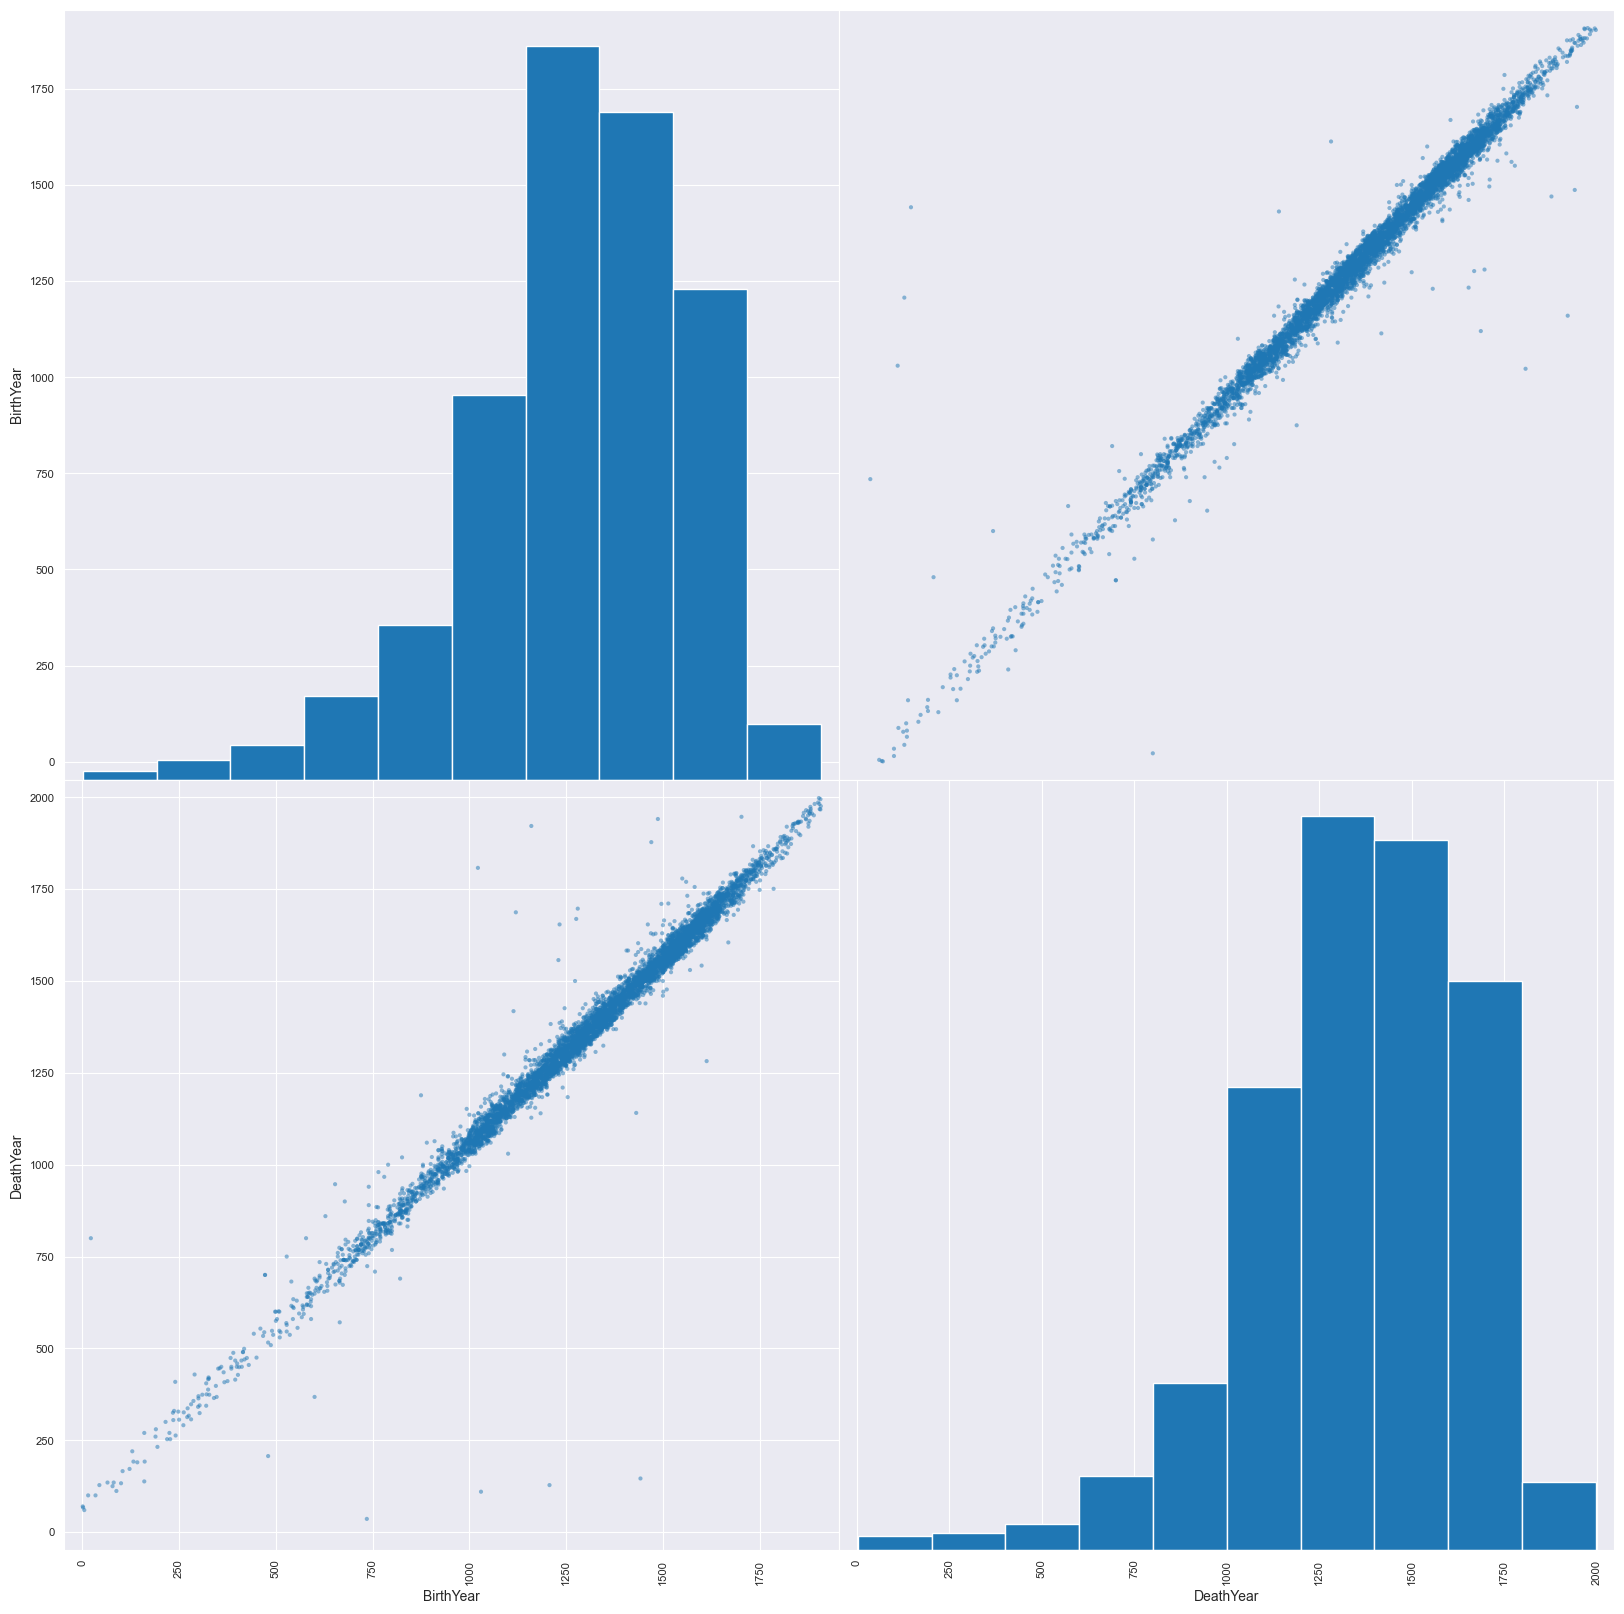

In [243]:
# check histogram of Birth and Death Dates and expect diagonal scatter plot
pd.plotting.scatter_matrix(ad_df,figsize=(20,20),grid=True)

#### This data is not "normally distributed" - each tail on the histogram has a different root cause.  The right tail reflect the exponential growth as you go back in time:  1 child -> 2 parents - > 4 grandparents -> 16 greatgrandparents....  The left tail reflects 2 factors:  1) the lack of historical records, i.e. the genealogy comes to a roadblock and ends even though the ancestors did exist, and 2) going back more than 6-12 generations there starts to be common ancestors - a 10th great grandparent appears as the ancestor to multiple lines; this is especially true for small communities in medival and earlier times where every marriage candidate was related as a 5th, 6th, .... cousin.

####  Most dates fall on the diagonal, but the outliers from the diagonal show incorrect data from the genealogy - birth and death dates too far apart to be humanly posssible.  

### Conclusion:  records with birth and death years more than 100 years apart need to be identified and marked for handling in the data set used for modeling


<Axes: title={'center': 'Death Years'}, ylabel='Frequency'>

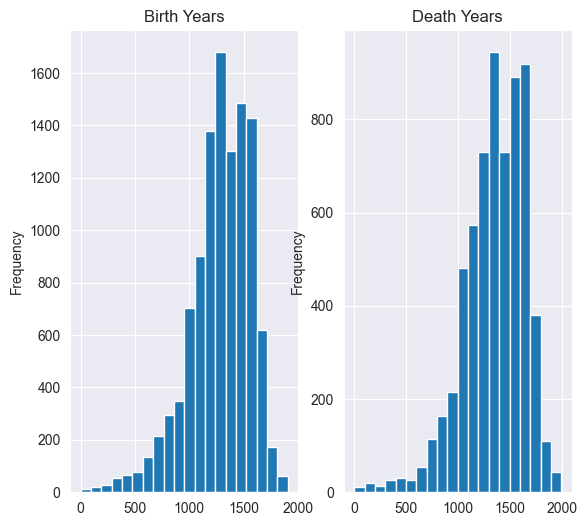

In [244]:
# more resolution on date histograms, 20 bins for 20 centuries of dates
plt.figure(figsize=(10,6))
plt.subplot(131)
ad_df["BirthYear"].plot.hist(bins=20, title="Birth Years")
plt.subplot(132)
ad_df["DeathYear"].plot.hist(bins=20, title="Death Years")

In [245]:
# Historical data tends to record men more than women, so this genealogy probably has more male than female
ad_df['Sex'].value_counts()

Sex
M    6082
F    5560
Name: count, dtype: int64

In [246]:
ad_df['EstCountry'].value_counts()

EstCountry
England            7084
France              987
UNKNOWN             866
Wales               707
United States       564
Scotland            256
Germany             233
Netherlands         133
Ireland             123
Italy               111
Norway               93
Denmark              86
Spain                47
Sweden               46
Prussia              45
Belgium              38
Switzerland          31
Hungary              25
Turkey               21
Luxembourg           17
Poland               16
Austria              16
Czechoslovakia       15
Russia                9
Channel Islands       7
Israel                7
Portugal              6
Iceland               6
Isle of Man           5
Unknown               5
ENGLAND               5
england               4
Finland               4
Ukraine               3
Swabia                3
ITALY                 3
NORWAY                2
Heruli                2
Egypt                 2
Iraq                  2
WALES                 2
Roman

#### "Estimated Countries" results from several semi-automated and manual processes, needs to be cleaned - "UNKNOWN" and "Unknown", England - ENGLAND - england, Wales and WALES, mix of UPPER CASE and Title Case

### Note:  this naming convention does not use "United Kingdom", it breaks out Ireland, Wales, Scotland and England to identify ethinic groupings.  The geocoded standard placenames all use "United Kingdom", which obscures the desired visibility into historical ethinic groups.

### Conclusion:  there are many countries with only a few ancestors, probably individuals and not family groups that made major moves...or some of these countries made be mistakes or mispellings in the genealogical data...either way they do not represent established family groups to track and should be removed from the data set for modeling

In [247]:
# clean up countries by setting to standard names
def standard_country_names(df, column_name):
    """
    Standardize country names in the specified column.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing country names
    column_name : str
        Column name containing country values
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standardized country names
    """
    df_copy = df.copy()
    df_copy.loc[df_copy[column_name] == 'Unknown', column_name] = 'UNKNOWN'
    df_copy.loc[df_copy[column_name] == 'england', column_name] = 'England'
    df_copy.loc[df_copy[column_name] == 'ENGLAND', column_name] = 'England'
    df_copy.loc[df_copy[column_name] == 'AUSTRIA', column_name] = 'Austria'
    df_copy.loc[df_copy[column_name] == 'ITALY', column_name] = 'Italy'
    df_copy.loc[df_copy[column_name] == 'NORWAY', column_name] = 'Norway'
    df_copy.loc[df_copy[column_name] == 'WALES', column_name] = 'Wales'
    df_copy.loc[df_copy[column_name] == 'Channel Islands', column_name] = 'England'

    return df_copy

ad_sc_df = standard_country_names(ad_df,'EstCountry')
ad_sc_df['EstCountry'].value_counts()

EstCountry
England           7100
France             987
UNKNOWN            871
Wales              709
United States      564
Scotland           256
Germany            233
Netherlands        133
Ireland            123
Italy              114
Norway              95
Denmark             86
Spain               47
Sweden              46
Prussia             45
Belgium             38
Switzerland         31
Hungary             25
Turkey              21
Luxembourg          17
Austria             17
Poland              16
Czechoslovakia      15
Russia               9
Israel               7
Portugal             6
Iceland              6
Isle of Man          5
Finland              4
Ukraine              3
Swabia               3
Heruli               2
Egypt                2
Iraq                 2
Romania              1
Barbados             1
Colombia             1
Sardinia             1
Name: count, dtype: int64

In [248]:
# make list of countries having large enough population for modeling
country_cnts_df = pd.DataFrame(ad_sc_df['EstCountry'].value_counts().reset_index())
select_country_cnts_df = country_cnts_df[country_cnts_df['count'] > 25].copy()
select_country_cnts_df

,EstCountry,count
0,England,7100
1,France,987
2,UNKNOWN,871
3,Wales,709
4,United States,564
5,Scotland,256
6,Germany,233
7,Netherlands,133
8,Ireland,123
9,Italy,114


In [249]:
# focus on the individuals in the selected countries
# removing the individuals from small population countries might break child-parent links and limit identification of family 
# groups and communities, so keep them in but set their country name to 'Outlier' to identify unusual migrations
ad_oc_df = ad_sc_df.copy()
ad_oc_df.loc[~(ad_oc_df['EstCountry'].isin(select_country_cnts_df['EstCountry'])), 'EstCountry'] = 'OUTLIER'
ad_oc_df['EstCountry'].value_counts()

EstCountry
England          7100
France            987
UNKNOWN           871
Wales             709
United States     564
Scotland          256
Germany           233
OUTLIER           164
Netherlands       133
Ireland           123
Italy             114
Norway             95
Denmark            86
Spain              47
Sweden             46
Prussia            45
Belgium            38
Switzerland        31
Name: count, dtype: int64

In [250]:
# setup encoding for countries
country_cnts_df = pd.DataFrame(ad_oc_df['EstCountry'].value_counts().reset_index())
select_country_cnts_df = country_cnts_df[country_cnts_df['count'] > 25].copy()
select_country_cnts_df['country_code'] = [len(select_country_cnts_df) - x for x in select_country_cnts_df['EstCountry'].index]
select_country_cnts_df

,EstCountry,count,country_code
0,England,7100,18
1,France,987,17
2,UNKNOWN,871,16
3,Wales,709,15
4,United States,564,14
5,Scotland,256,13
6,Germany,233,12
7,OUTLIER,164,11
8,Netherlands,133,10
9,Ireland,123,9


In [251]:
# confirm no rows lost
ad_oc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11642 entries, 0 to 11641
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   INDI_ID     11642 non-null  object 
 1   Surname     10770 non-null  object 
 2   Sex         11642 non-null  object 
 3   BirthYear   10983 non-null  float64
 4   BirthPlace  10124 non-null  object 
 5   DeathYear   6483 non-null   float64
 6   DeathPlace  4242 non-null   object 
 7   Father_ID   6038 non-null   object 
 8   Mother_ID   5602 non-null   object 
 9   FAMS_ID1    11642 non-null  object 
 10  Spouse_ID   10764 non-null  object 
 11  FromChild   11634 non-null  object 
 12  EstCountry  11642 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.2+ MB


In [252]:
# Address null values - set to 'UNKNOWN' for use in model calculations
def standardize_null_values(df, column_name_list, value):
    """
    Standardize country names in the specified columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing ancestor data with null values
    column_name_list : list
        List of Column names to update to value
    value : 
        The value to replace null values
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with null values replaced
    """
    df_copy = df.copy()
    for column_name in column_name_list:
        df_copy[column_name] = df_copy[column_name].fillna(value)

    return df_copy

unknown_cols_list = ['Surname','BirthPlace','DeathPlace','Father_ID','Mother_ID','Spouse_ID','FromChild']
maxyear_cols_list = ['BirthYear','DeathYear']
adn_u_df = standardize_null_values(ad_oc_df, unknown_cols_list, 'UNKNOWN')
adn_c_df = standardize_null_values(adn_u_df, maxyear_cols_list, 99999)

# confirm no nulls in fields used in modeling
adn_c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11642 entries, 0 to 11641
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   INDI_ID     11642 non-null  object 
 1   Surname     11642 non-null  object 
 2   Sex         11642 non-null  object 
 3   BirthYear   11642 non-null  float64
 4   BirthPlace  11642 non-null  object 
 5   DeathYear   11642 non-null  float64
 6   DeathPlace  11642 non-null  object 
 7   Father_ID   11642 non-null  object 
 8   Mother_ID   11642 non-null  object 
 9   FAMS_ID1    11642 non-null  object 
 10  Spouse_ID   11642 non-null  object 
 11  FromChild   11642 non-null  object 
 12  EstCountry  11642 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.2+ MB


    

### Ancestor Relationships Representation for Modeling

![Lineage Graph](https://github.com/user-attachments/assets/48271115-551d-43fc-9bbc-39f20584f3af)

The Ancestor_data.csv has already converted the basic genealogy graph data to denormalized relationships data in each individuals record - the individual's father, mother, spouse and child of direct descent.  We need to further denormalize the attributes needed for modeling for each relationship:  birthyear, surname, sex and estimated birth country.   


In [259]:
# denormalize family graph data to provide input structured for modeling
# Attach father, mother, child attribute data to each individual
# do not attach spouse to avoid double counting because each spouse is an individual

def denormalize_family_graph(df,column_list,types_list, merge_col):
    """
    denormalize family graph data to provide input structured for modeling.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing country names
    column_list : list
        List of Columns to denormalize
    types_list : list
        List of types of graph nodes to denormalize
    merge_col : str
        name of column to merge for denormalization
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with graph data denormalized 
    """
    df_copy = df.copy()
    types_df_list = []
    merge_col_list = []
    # for each type generate names for denormalized columns
    for node in types_list:
        col_prefix = node[0] + '_'
        type_df = df_copy[column_list].copy()
        name_list = []
        for col in column_list:
            denorm_name = col_prefix + col
            name_list.append(denorm_name)
            if merge_col == col:
                merge_col_list.append(denorm_name)
        type_df.columns = name_list
        types_df_list.append(type_df)
        
    # merge denormalize records with each record
    for type_df, node, merge_key in zip(types_df_list,types_list,merge_col_list):
        df_copy = pd.merge(df_copy, type_df, how='left', 
                            left_on = node, right_on = merge_key)

    return df_copy

# standard name convention - first letter of type used  in denormalized col names
# so 1st letter must be unique
adn_c_df['Child_ID'] = adn_c_df['FromChild'] 
# setup for denormalization
denorm_cols_list = ['INDI_ID','Surname','Sex','BirthYear','EstCountry']
denorm_types_list = ['Father_ID','Mother_ID','Child_ID']

ad_dn_df = denormalize_family_graph(adn_c_df,denorm_cols_list,denorm_types_list, 'INDI_ID')

# keep original code so I know what the hell the above "DRY" function is supposed to do

#fathers_df = adn_c_df[['INDI_ID','Surname','Sex','BirthYear','EstCountry']].copy()
#fathers_df.columns = ['F_INDI_ID','F_Surname','F_Sex','F_BirthYear','F_EstCountry']
#mothers_df = adn_c_df[['INDI_ID','Surname','Sex','BirthYear','EstCountry']].copy()
#mothers_df.columns = ['M_INDI_ID','M_Surname','M_Sex','M_BirthYear','M_EstCountry']
#children_df = adn_c_df[['INDI_ID','Surname','Sex','BirthYear','EstCountry']].copy()
#children_df.columns = ['C_INDI_ID','C_Surname','C_Sex','C_BirthYear','C_EstCountry']

# add connected family to each individual
#ad_dn_df = pd.merge(adn_c_df, fathers_df, how='left', left_on = 'Father_ID', right_on = 'F_INDI_ID')
#ad_dn_df = pd.merge(ad_dn_df, mothers_df, how='left', left_on = 'Mother_ID',, right_on = 'M_INDI_ID')
#ad_dn_df = pd.merge(ad_dn_df, children_df, how='left', left_on = 'FromChild', right_on = 'C_INDI_ID')

# address new null values

unknown_cols_list = ['F_INDI_ID','F_Surname','F_Sex','F_EstCountry','M_INDI_ID','M_Surname','M_Sex','M_EstCountry',
                     'C_INDI_ID','C_Surname','C_Sex','C_EstCountry']
maxyear_cols_list = ['F_BirthYear','M_BirthYear','C_BirthYear']
adn_dnns_df = standardize_null_values(ad_dn_df, unknown_cols_list, 'UNKNOWN')
adn_dnnn_df = standardize_null_values(adn_dnns_df, maxyear_cols_list, 99999)

# check for same number of records (no merge multiplication) and no null values
adn_dnnn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11642 entries, 0 to 11641
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   INDI_ID       11642 non-null  object 
 1   Surname       11642 non-null  object 
 2   Sex           11642 non-null  object 
 3   BirthYear     11642 non-null  float64
 4   BirthPlace    11642 non-null  object 
 5   DeathYear     11642 non-null  float64
 6   DeathPlace    11642 non-null  object 
 7   Father_ID     11642 non-null  object 
 8   Mother_ID     11642 non-null  object 
 9   FAMS_ID1      11642 non-null  object 
 10  Spouse_ID     11642 non-null  object 
 11  FromChild     11642 non-null  object 
 12  EstCountry    11642 non-null  object 
 13  Child_ID      11642 non-null  object 
 14  F_INDI_ID     11642 non-null  object 
 15  F_Surname     11642 non-null  object 
 16  F_Sex         11642 non-null  object 
 17  F_BirthYear   11642 non-null  float64
 18  F_EstCountry  11642 non-nu

In [260]:
adn_dnnn_df.head(10)


,INDI_ID,Surname,Sex,BirthYear,BirthPlace,DeathYear,DeathPlace,Father_ID,Mother_ID,FAMS_ID1,...,M_INDI_ID,M_Surname,M_Sex,M_BirthYear,M_EstCountry,C_INDI_ID,C_Surname,C_Sex,C_BirthYear,C_EstCountry
0,I10,Steffen,M,1890.0,"Stettin, Marathon, WI",1951.0,"Oakland, Alameda, California, United States",I19,I20,F3,...,I20,Hieronimus,F,1850.0,Prussia,UNKNOWN,UNKNOWN,UNKNOWN,99999.0,UNKNOWN
1,I11,Turner,F,1892.0,"Oldham, Lancashire, England",1982.0,"Oakland, Alameda, California, United States",I16,I17,F3,...,I17,Wolfenden,F,1864.0,England,UNKNOWN,UNKNOWN,UNKNOWN,99999.0,UNKNOWN
2,I12,Hastings,M,1907.0,"Mesa, Maricopa, Arizona, USA",1967.0,"Mesa, Maricopa, Arizona, USA",I24,I25,F4,...,I25,Dennett,F,1875.0,United States,UNKNOWN,UNKNOWN,UNKNOWN,99999.0,UNKNOWN
3,I13,Hinton,F,1908.0,"La Verkin,Washington,Utah",1976.0,"Mesa, Maricopa, Arizona, USA",I21,I22,F4,...,I22,Sanders,F,1875.0,United States,UNKNOWN,UNKNOWN,UNKNOWN,99999.0,UNKNOWN
4,I16,Turner,M,1870.0,"Oldham, Lancashire, England",1965.0,"Oldham, Lancashire, England",I55,I56,F6,...,I56,UNKNOWN,F,1836.0,England,I11,Turner,F,1892.0,England
5,I17,Wolfenden,F,1864.0,"Halifax, Yorkshire, England",1958.0,"Oldham, Lancashire, England",I57,I58,F6,...,I58,Wolfenden,F,99999.0,England,I11,Turner,F,1892.0,England
6,I19,Steffen,M,1835.0,"Meesow, Regenwalde, Pommern, Prussia",1922.0,"Stettin, Marathon, WI",I38,I39,F7,...,I39,Glebcken,F,1802.0,Prussia,I10,Steffen,M,1890.0,United States
7,I20,Hieronimus,F,1850.0,"Neu Maldewin, Regenwalde, Pomerania, Prussia",1930.0,"Stettin, Marathon, WI",I30,I31,F7,...,I31,Beggerow,F,1814.0,Prussia,I10,Steffen,M,1890.0,United States
8,I21,Hinton,M,1870.0,"Virgin, Washington, Utah, USA",1940.0,"Hurricane,Washington,Utah,United States",I36,I10400,F8,...,I10400,Spendlove,F,1842.0,England,I13,Hinton,F,1908.0,United States
9,I22,Sanders,F,1875.0,"Washington, Washington, Utah, USA",1962.0,"St. George,Washington,Ut",I12054,I41,F8,...,I41,Zabriskie,F,1844.0,United States,I13,Hinton,F,1908.0,United States


In [261]:
# approximation for unknown birth years
# set to parents birth year + 25, else child birth year - 25, else calculate based on depth in list
ad_cm_df = adn_dnnn_df.copy()
cnt = 0
ncnt = 0
for i, year in enumerate(ad_cm_df['BirthYear']):
    if year == 99999: 
        parent_year = min(ad_cm_df.loc[i,'F_BirthYear'], ad_cm_df.loc[i,'M_BirthYear'], ad_cm_df.loc[i,'C_BirthYear'])
        if parent_year == 99999:
            if ad_cm_df.loc[i,'C_BirthYear'] == 99999:
                est_year = 1800 - (len(ad_cm_df) / 1900  * (1 + int(i / 100)))
                ncnt += 1
            else:
                est_year = ad_cm_df.loc[i,'C_BirthYear'] - 25
        else:
            est_year = parent_year + 25
        print(i,est_year, ad_cm_df.loc[i,'F_BirthYear'], ad_cm_df.loc[i,'M_BirthYear'], ad_cm_df.loc[i,'C_BirthYear'])
        cnt += 1 
        ad_cm_df.loc[i,'BirthYear'] = est_year

print('cnt=',cnt,ncnt)

16 1875.0 99999.0 99999.0 1850.0
33 1889.0 99999.0 99999.0 1864.0
34 1827.0 99999.0 99999.0 1802.0
36 1805.0 99999.0 99999.0 1780.0
37 1805.0 99999.0 99999.0 1780.0
126 1710.0 99999.0 99999.0 1685.0
166 1703.0 99999.0 99999.0 1678.0
207 1700.0 99999.0 99999.0 1675.0
295 1639.0 99999.0 99999.0 1614.0
409 1633.0 99999.0 99999.0 1608.0
410 1633.0 99999.0 99999.0 1608.0
411 1637.0 99999.0 99999.0 1612.0
412 1637.0 99999.0 99999.0 1612.0
460 1649.0 99999.0 99999.0 1624.0
484 1635.0 99999.0 99999.0 1610.0
499 1522.0 1497.0 1506.0 1548.0
541 1600.0 99999.0 99999.0 1575.0
588 1605.0 99999.0 99999.0 1580.0
589 1605.0 99999.0 99999.0 1580.0
610 1583.0 99999.0 99999.0 1558.0
632 1591.0 99999.0 99999.0 1566.0
633 1591.0 99999.0 99999.0 1566.0
634 1610.0 99999.0 99999.0 1585.0
704 1637.0 99999.0 99999.0 1612.0
777 1585.0 99999.0 99999.0 1560.0
778 1585.0 99999.0 99999.0 1560.0
1033 1671.0 99999.0 99999.0 1646.0
1119 1604.0 99999.0 99999.0 1579.0
1120 1604.0 99999.0 99999.0 1579.0
1273 1602.0 99999.

In [263]:
# confirm range of Birth years with approximated values - original mean from ad_df.describe() was 1311
print(ad_df['BirthYear'].min(), ad_df['BirthYear'].mean(),ad_df['BirthYear'].max())
print(adn_dnnn_df['BirthYear'].min(), adn_dnnn_df['BirthYear'].mean(),adn_dnnn_df['BirthYear'].max())
print(ad_cm_df['BirthYear'].min(), ad_cm_df['BirthYear'].mean(),ad_cm_df['BirthYear'].max())


1.0 1282.8498588728035 1908.0
1.0 6870.716457653324 99999.0
1.0 1281.3774650765379 1908.0


<Axes: title={'center': 'Approximated Birth Years'}, ylabel='Frequency'>

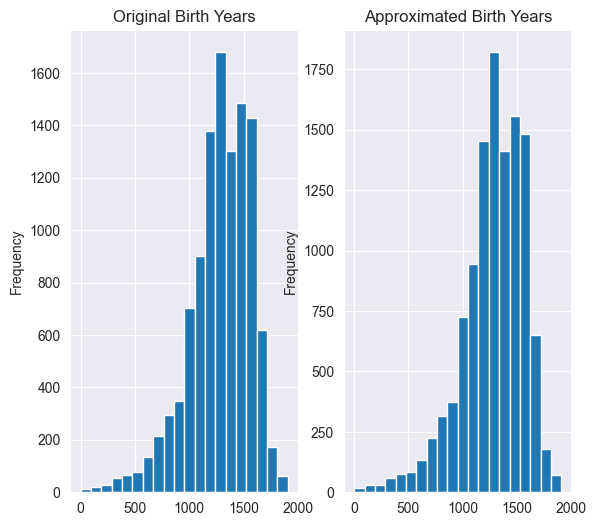

In [264]:
# review updated Birth Year histograms for changes in distribution, 20 bins for 20 centuries of dates
plt.figure(figsize=(10,6))
plt.subplot(131)
ad_df["BirthYear"].plot.hist(bins=20, title="Original Birth Years")
plt.subplot(132)
ad_cm_df["BirthYear"].plot.hist(bins=20, title="Approximated Birth Years")


In [24]:
# review Geocoded Place data
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28284 entries, 0 to 28283
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PlaceName  28284 non-null  object 
 1   MatchedTo  28284 non-null  object 
 2   Latitude   28284 non-null  float64
 3   Longitude  28284 non-null  float64
 4   Events     28284 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.1+ MB


#### No null values, Lat/Long in correct float datatype

#### PlaceName was generated from the BirthPlace and DeathPlace fields in the Ancestor Data file, so will provide the key field for joining / merging the two datasets

#### MatchTo gives the standardized names of locations, including the Country based on current or modern countries.

In [25]:
# check range of lat & long
geo_df.describe()

,Latitude,Longitude,Events
count,28284.000000,28284.000000,28284.000000
mean,49.316779,-18.016392,2.703012
std,6.587805,34.499436,21.367095
min,-46.250000,-157.071390,1.000000
25%,47.000000,-4.559892,1.000000
50%,51.740725,-2.014388,1.000000
75%,52.596108,-0.178401,2.000000
max,72.166667,176.833333,3120.000000


array([[<Axes: xlabel='Latitude', ylabel='Latitude'>,
        <Axes: xlabel='Longitude', ylabel='Latitude'>,
        <Axes: xlabel='Events', ylabel='Latitude'>],
       [<Axes: xlabel='Latitude', ylabel='Longitude'>,
        <Axes: xlabel='Longitude', ylabel='Longitude'>,
        <Axes: xlabel='Events', ylabel='Longitude'>],
       [<Axes: xlabel='Latitude', ylabel='Events'>,
        <Axes: xlabel='Longitude', ylabel='Events'>,
        <Axes: xlabel='Events', ylabel='Events'>]], dtype=object)

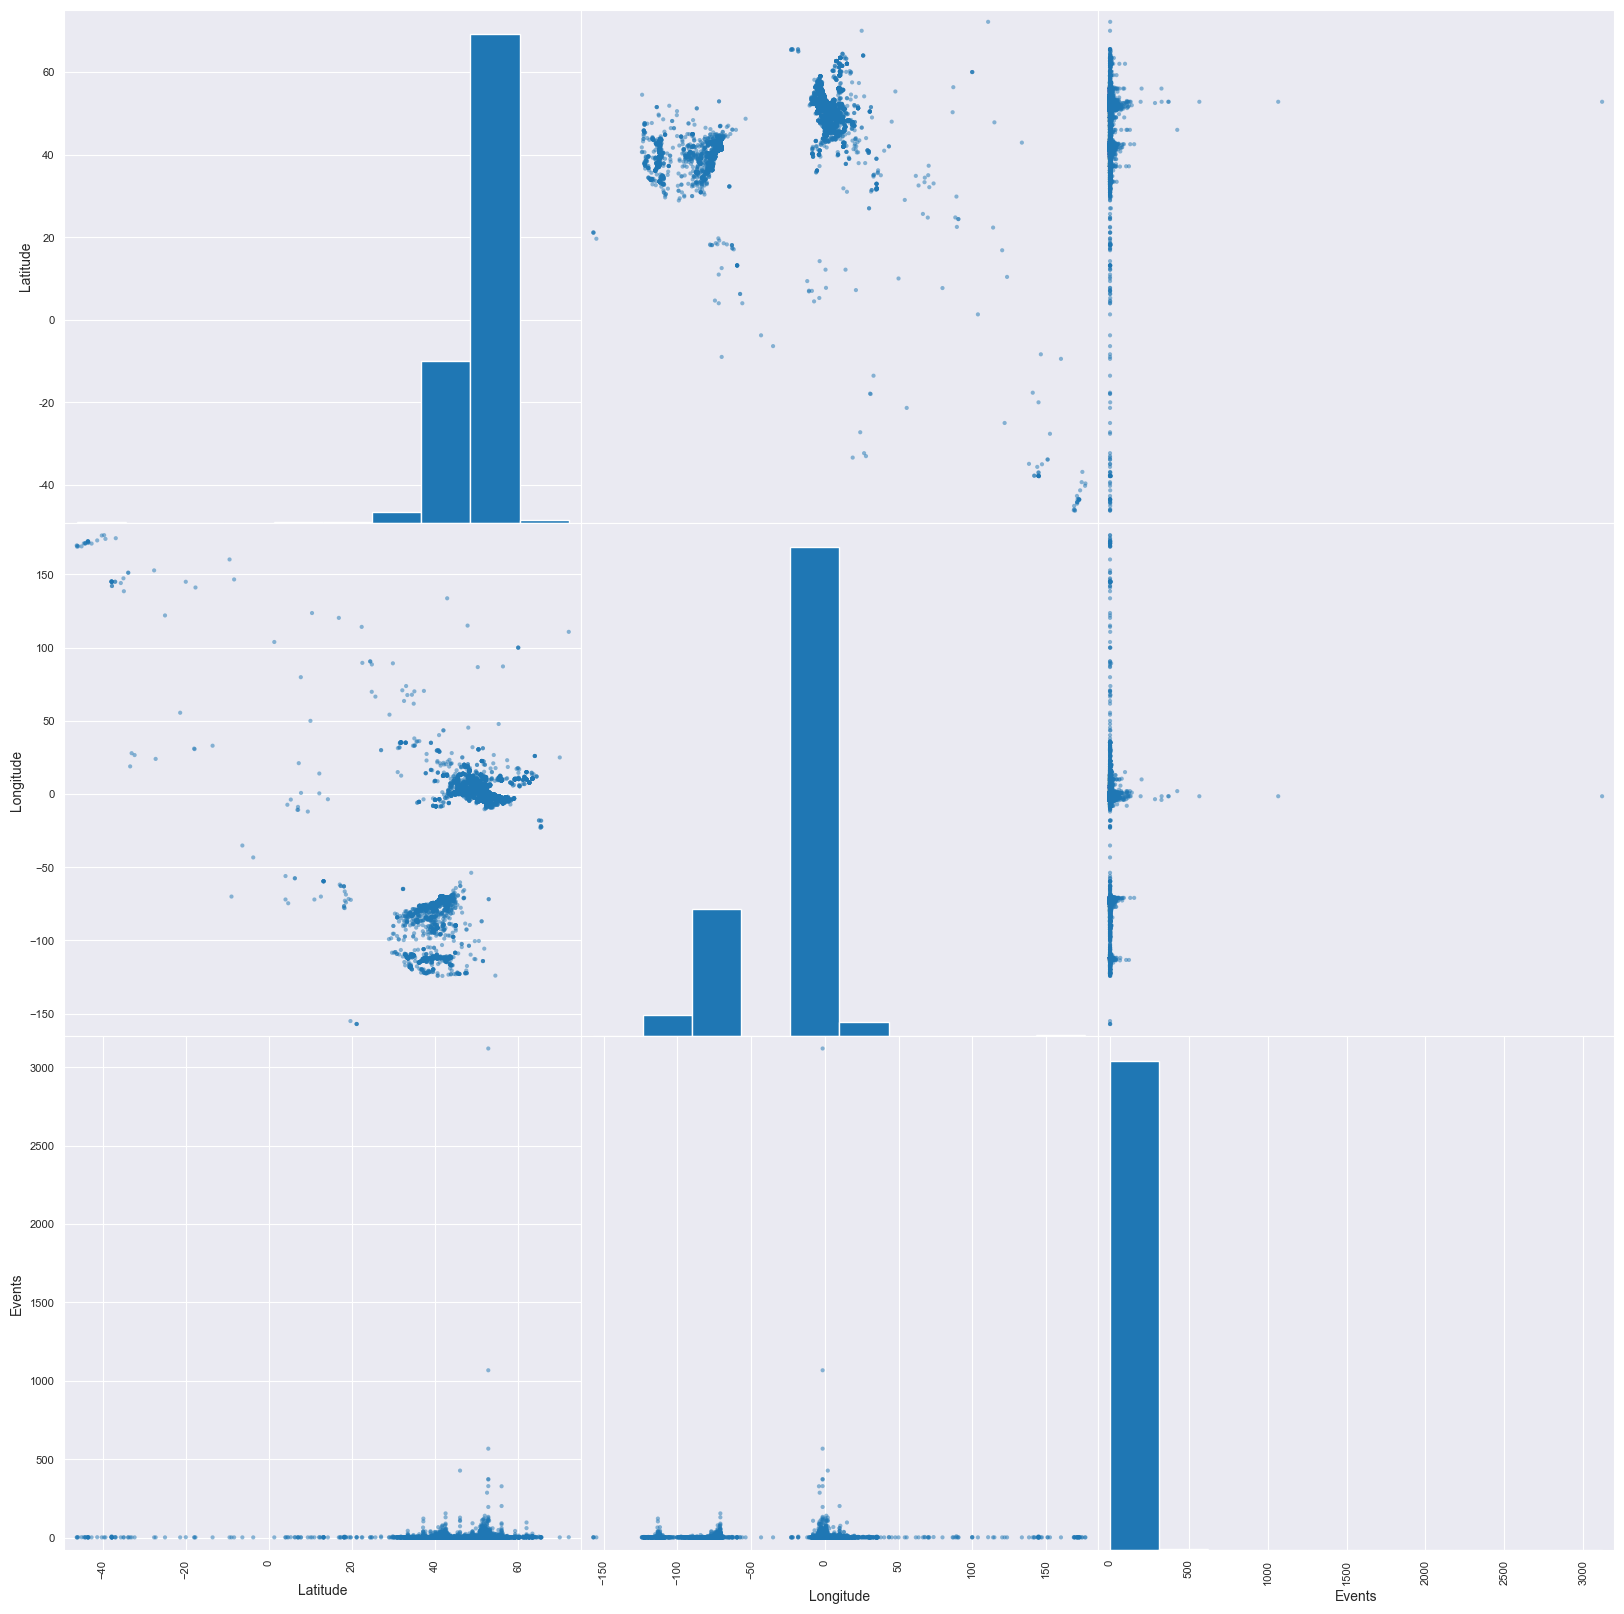

In [26]:
# check histogram of lat & long, and expect to see rough outline of North America and Europe in the scatter plot
pd.plotting.scatter_matrix(geo_df,figsize=(20,20),grid=True)

#### Top center scatter plot clearly shows majority of locations outlining North America and Europe / British Isles, however there are many outliers in Asia and the Southern hemisphere which are incorrect geocoding due to matches between misspelled Places in the source genealogy data and the geocoding database of world locations.  In the lower right corner the outlines of New Zealand and the west coast of Austrailia can been seen, but no ancestors lived in these countries.   

### Conclusion:  the source genealogy place name data has a wide variety of formats and a significant number of misspellings and typos, which the geocoding tool cannot match accurately or even mismatches with locations 1000's of miles away from the actual location.  The geocoding should be rerun after data cleaning of the source Place Names, and ambiguous place names that cannot be cleaned should not be geocoded.  Alternate methods need to be used to triangulate on the approximate location of ambiguous place names.

<Axes: title={'center': 'Longitude'}, ylabel='Frequency'>

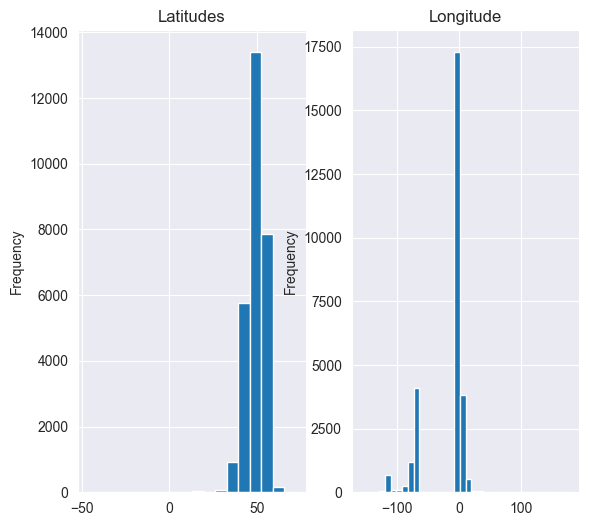

In [27]:
# more resolution on lat long histograms, 18 bins for lat (+/-90 degrees), 36 bins for long (+/- 180 degrees)
plt.figure(figsize=(10,6))
plt.subplot(131)
geo_df["Latitude"].plot.hist(bins=18, title="Latitudes")
plt.subplot(132)
geo_df["Longitude"].plot.hist(bins=36, title="Longitude")

#### Majority of latitutes in range 40-60 degress North, the location of North America and Europe / Britsh Isles
#### Majority of longitudes at 0 degrees which is the Britsh Isles, with secondary peaks for Europe and the east coast of the US.  Notably there are clear gaps for the Atlantic Ocean and the US Rocky Mountains

# Modeling  

Convert variables to numbers in range 0-1

setup Logistic Regression model


In [265]:
# scale Birth Year to range of 0-1
model_df = ad_cm_df.copy()
minYear = model_df['BirthYear'].min()
maxminDiff = model_df['BirthYear'].max() - minYear
model_df['BirthYearScaled'] = [(x - minYear) / maxminDiff for x in model_df['BirthYear']]
model_df['BirthYearScaled'].describe()

count    11642.000000
mean         0.671409
std          0.151415
min          0.000000
25%          0.594127
50%          0.686943
75%          0.786576
max          1.000000
Name: BirthYearScaled, dtype: float64

In [266]:
# Encode Categorical variables
# don't need Father and Mother Sex Codes because the information is inherent in the F_ and M_ columns
model_df['SexCode'] = [0 if x == 'M' else 1 for x in model_df['Sex']]
model_df['C_SexCode'] = [0 if x == 'M' else 1 if x == 'F' else -1 for x in model_df['C_Sex']]

#enc = preprocessing.OrdinalEncoder()
#enc.fit(model_df[['','','','','','']])

model_df[['SexCode','C_SexCode']].describe()

,SexCode,C_SexCode
count,11642.000000,11642.000000
mean,0.477581,0.409380
std,0.499519,0.493136
min,0.000000,-1.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [267]:
# encode countries
select_country_cnts_df.columns = ['EstCountry','count','country_code']
model_df = pd.merge(model_df, select_country_cnts_df[['EstCountry','country_code']], how='left', 
                    left_on = 'EstCountry', right_on = 'EstCountry')
select_country_cnts_df.columns = ['F_EstCountry','count','F_country_code']
model_df = pd.merge(model_df, select_country_cnts_df[['F_EstCountry','F_country_code']], how='left', 
                    left_on = 'F_EstCountry', right_on = 'F_EstCountry')
select_country_cnts_df.columns = ['M_EstCountry','count','M_country_code']
model_df = pd.merge(model_df, select_country_cnts_df[['M_EstCountry','M_country_code']], how='left', 
                    left_on = 'M_EstCountry', right_on = 'M_EstCountry')
select_country_cnts_df.columns = ['C_EstCountry','count','C_country_code']
model_df = pd.merge(model_df, select_country_cnts_df[['C_EstCountry','C_country_code']], how='left', 
                    left_on = 'C_EstCountry', right_on = 'C_EstCountry')
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11642 entries, 0 to 11641
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   INDI_ID          11642 non-null  object 
 1   Surname          11642 non-null  object 
 2   Sex              11642 non-null  object 
 3   BirthYear        11642 non-null  float64
 4   BirthPlace       11642 non-null  object 
 5   DeathYear        11642 non-null  float64
 6   DeathPlace       11642 non-null  object 
 7   Father_ID        11642 non-null  object 
 8   Mother_ID        11642 non-null  object 
 9   FAMS_ID1         11642 non-null  object 
 10  Spouse_ID        11642 non-null  object 
 11  FromChild        11642 non-null  object 
 12  EstCountry       11642 non-null  object 
 13  Child_ID         11642 non-null  object 
 14  F_INDI_ID        11642 non-null  object 
 15  F_Surname        11642 non-null  object 
 16  F_Sex            11642 non-null  object 
 17  F_BirthYear 

In [268]:
# double check country codes
model_df[model_df['country_code'].isnull()].head()


,INDI_ID,Surname,Sex,BirthYear,BirthPlace,DeathYear,DeathPlace,Father_ID,Mother_ID,FAMS_ID1,...,C_Sex,C_BirthYear,C_EstCountry,BirthYearScaled,SexCode,C_SexCode,country_code,F_country_code,M_country_code,C_country_code


In [270]:
# double check country codes
model_df['country_code'].value_counts()

country_code
18    7100
17     987
16     871
15     709
14     564
13     256
12     233
11     164
10     133
9      123
8      114
7       95
6       86
5       47
4       46
3       45
2       38
1       31
Name: count, dtype: int64

In [271]:
# double check country codes
model_df[['F_EstCountry','F_country_code']].value_counts()

F_EstCountry   F_country_code
UNKNOWN        16                6066
England        18                3685
France         17                 515
Wales          15                 393
United States  14                 249
Scotland       13                 133
Germany        12                 115
OUTLIER        11                  82
Netherlands    10                  69
Ireland        9                   66
Italy          8                   63
Norway         7                   50
Denmark        6                   48
Sweden         4                   27
Prussia        3                   22
Belgium        2                   22
Spain          5                   21
Switzerland    1                   16
Name: count, dtype: int64

In [272]:
# double check country codes
model_df[['M_EstCountry','M_country_code']].value_counts()

M_EstCountry   M_country_code
UNKNOWN        16                6453
England        18                3414
France         17                 472
Wales          15                 316
United States  14                 308
Scotland       13                 123
Germany        12                 118
OUTLIER        11                  82
Netherlands    10                  65
Ireland        9                   57
Italy          8                   51
Norway         7                   46
Denmark        6                   38
Spain          5                   26
Prussia        3                   23
Sweden         4                   19
Belgium        2                   16
Switzerland    1                   15
Name: count, dtype: int64

In [273]:
# double check country codes
model_df[['C_EstCountry','C_country_code']].value_counts()

C_EstCountry   C_country_code
England        18                7251
United States  14                 901
France         17                 883
Wales          15                 752
UNKNOWN        16                 430
Scotland       13                 274
Germany        12                 221
OUTLIER        11                 153
Italy          8                  131
Netherlands    10                 126
Ireland        9                  115
Norway         7                  104
Denmark        6                   91
Prussia        3                   53
Spain          5                   48
Sweden         4                   42
Switzerland    1                   36
Belgium        2                   31
Name: count, dtype: int64

In [274]:
# for basic model use 6 features to predict the country
X = model_df[['BirthYearScaled','SexCode', 'C_SexCode','F_country_code','M_country_code','C_country_code']]
y = model_df['country_code']

type(X),type(y),X.shape, y.shape, X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11642 entries, 0 to 11641
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BirthYearScaled  11642 non-null  float64
 1   SexCode          11642 non-null  int64  
 2   C_SexCode        11642 non-null  int64  
 3   F_country_code   11642 non-null  int64  
 4   M_country_code   11642 non-null  int64  
 5   C_country_code   11642 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 545.8 KB


(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 (11642, 6),
 (11642,),
 None)

In [275]:
# model as a linear classification problem so use Logistics Regression
model = LogisticRegression(max_iter=10000)

In [276]:
# setup training and test data
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [277]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
#scoring 
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred, average='micro')
Recall = recall_score(y_test, y_pred, average='micro')
F1 = f1_score(y_test, y_pred, average='micro')
print("Scores")
print("Accuracy -->",Accuracy)
print("Precision -->",Precision)
print("Recall -->",Recall)
print("F1 -->",F1)


Scores
Accuracy --> 0.6510163183509877
Precision --> 0.6510163183509877
Recall --> 0.6510163183509877
F1 --> 0.6510163183509877


In [278]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[   0,    0,    0,    3,    1,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    2,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    0,    1,    2,    0,    2,    5],
       [   0,    0,    0,    1,    2,    1,    0,    0,    0,    7,    0,
           3,    1,    2,    1,    2,    1,    0],
       [   0,    0,    0,    0,    0,    7,    4,    0,    0,    0,    0,
           2,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    2,    0,    7,    0,
           2,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,    9,    5,    1,    0,    0,    0,
           5,    0,    0,    0,    0,    4,    1],
       [   0,    0,    0,    0,    0,    5,    2,    3,    0,    1,    1,
          10,    0,    1,    0,    0,    4,    0],
       [   0,    0,    0,    0,    1,    0,    2,    4,    0,    9,    0,
           9,    0,    0,    1,    0,    7,    1],


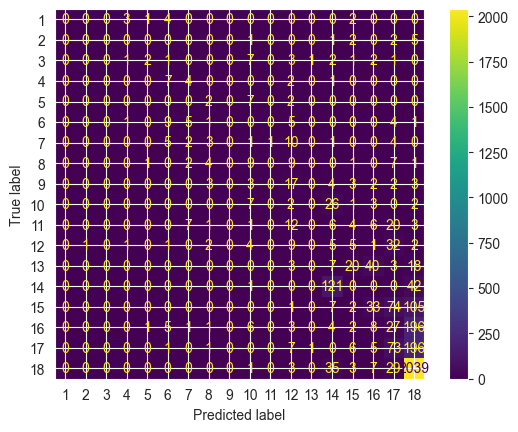

In [279]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)

## Initial model results - not very predictive of where and when migrations between countries will occur.  
### Analyze model details and rework data setup and model tuning


In [280]:
# Examine overall pattern of migration by comparing parent birth country with child birth country
# Children born in the same country as parent will appear on the diagonal
# Children born in a different country will appear off of the diagonal, indicating the parent migrated from their country
p_v_c_ctry_mat = pd.crosstab(model_df['country_code'],model_df['C_country_code'])
p_v_c_ctry_mat

C_country_code,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
country_code,,,,,,,,,,,,,,,,,,
1,20,0,0,0,0,0,0,3,0,0,0,6,0,0,0,0,0,2
2,0,12,0,0,0,0,0,0,0,2,1,3,0,0,0,3,15,2
3,0,0,25,0,0,0,0,0,0,2,0,11,0,2,0,2,3,0
4,0,0,0,27,0,6,6,0,2,0,1,1,0,1,0,0,2,0
5,0,0,0,0,38,0,0,0,0,0,2,0,0,0,1,2,2,2
6,0,0,0,4,0,63,7,0,0,0,4,1,0,1,0,2,2,2
7,0,0,0,6,0,4,70,0,0,2,2,2,0,0,0,0,4,5
8,1,0,0,0,0,0,1,87,0,0,3,4,1,0,0,5,8,4
9,0,0,0,0,0,0,0,0,86,0,0,1,2,5,6,0,0,23


Text(0.5, 1.0, 'Country changes from Parent to Child')

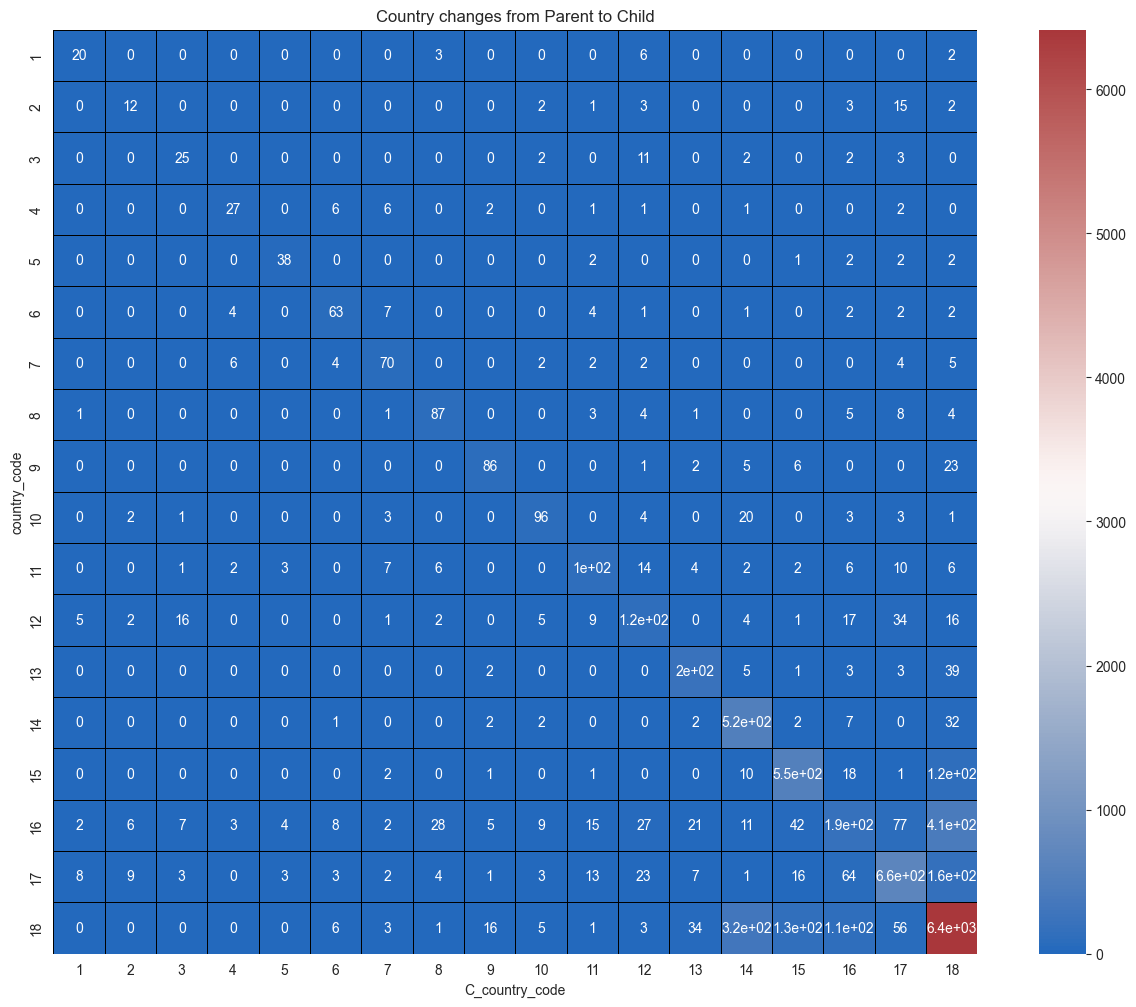

In [281]:
# try a heat map to visualize the migration patterns and volumes
plt.figure(figsize=(16,12))
sns.heatmap(p_v_c_ctry_mat,annot=True,square=True,  cmap="vlag",linewidths=0.6,linecolor="Black")
plt.title("Country changes from Parent to Child")

In [70]:
# lookup for Country Codes
select_country_cnts_df

,C_EstCountry,count,C_country_code
0,England,7100,18
1,France,987,17
2,UNKNOWN,871,16
3,Wales,709,15
4,United States,564,14
5,Scotland,256,13
6,Germany,233,12
7,OUTLIER,164,11
8,Netherlands,133,10
9,Ireland,123,9


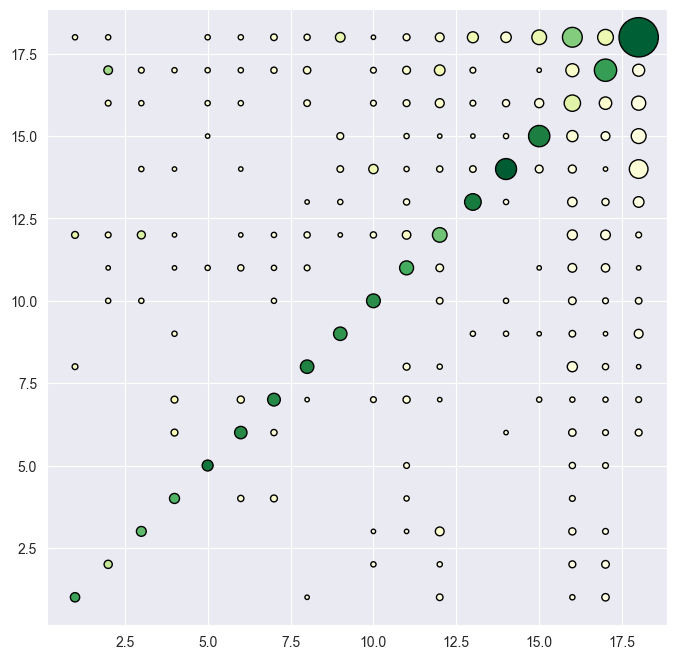

In [90]:
# Use a scatterplot, points on the diagonal are "no migration", points off the diagonal indication migration
# Scale volume data to better see patterns, and add percent of parent country volume as more useful metric
# Display volume by size of plot point and display Percent of Country Volume by color of plot point
p_v_c_ctry_df = pd.pivot_table(model_df, index=['country_code','C_country_code'], values=['INDI_ID'], aggfunc='count').reset_index()
ctry_codes_df = pd.DataFrame(model_df['country_code'].value_counts())
p_v_c_ctry_df['p_ctry_pct'] = 0.0
p_ctry_pct = []
for i, p_ctry in enumerate(p_v_c_ctry_df['country_code']):
    total = ctry_codes_df.loc[p_ctry,'count']
    #print(i,p_ctry,total)
    p_ctry_pct.append(p_v_c_ctry_df.loc[i,'INDI_ID'] / total)
p_v_c_ctry_df['p_ctry_pct'] = p_ctry_pct
size = np.sqrt(p_v_c_ctry_df['INDI_ID']) * 10 # exponential scale due to England being order-of-magnitude larger than all others
#size = p_v_c_ctry_df['INDI_ID']
color = p_v_c_ctry_df['p_ctry_pct'] 
plt.figure(figsize=(8,8))
plt.scatter(p_v_c_ctry_df['country_code'],p_v_c_ctry_df['C_country_code'],s=size, c=color, vmax=1, cmap="YlGn", edgecolors="k")
plt.show()

In [85]:
# Most countries have migration to most other countries at some point over the 2000 years of ancestor data
# Pattern not visible when looking at 2000 years of data - patterns probably occured at specific times in history
# compare parent country vs child's country by century to see migration patterns at specific periods in history

# 1st pass at time decomposition - use centuries to divide into 20 time periods
model_df['BirthCentury'] = [int(x/100)*100 for x in model_df['BirthYear']]
model_df['BirthCentury'].value_counts()

BirthCentury
1200    1823
1500    1801
1300    1681
1400    1382
1100    1146
1000    1043
1600     874
900      463
800      332
700      285
1700     238
600      154
500      107
1800      79
400       76
300       70
100       32
200       30
0         19
1900       7
Name: count, dtype: int64

In [158]:
# setup reference dictionary for time periods
BirthCentury_dict = pd.pivot_table(model_df, index=['BirthCentury'], values=['INDI_ID'], aggfunc='count').to_dict()['INDI_ID']
BirthCentury_dict

{0: 19,
 100: 32,
 200: 30,
 300: 70,
 400: 76,
 500: 107,
 600: 154,
 700: 285,
 800: 332,
 900: 463,
 1000: 1043,
 1100: 1146,
 1200: 1823,
 1300: 1681,
 1400: 1382,
 1500: 1801,
 1600: 874,
 1700: 238,
 1800: 79,
 1900: 7}

In [162]:
# setup reference dictionary for countries by time period
model_df['dictkeys'] = model_df['BirthCentury'].astype(str) + '-' + model_df['country_code'].astype(str)
ctry_codes_v_t_df = pd.DataFrame(model_df[['BirthCentury','country_code']].value_counts()).reset_index()
ctry_codes_v_t_dict = pd.DataFrame(model_df['dictkeys'].value_counts()).to_dict()['count']
ctry_codes_v_t_dict

{'1500-18': 1564,
 '1300-18': 1342,
 '1200-18': 1259,
 '1400-18': 1218,
 '1100-18': 748,
 '1000-17': 400,
 '1600-18': 380,
 '1600-14': 361,
 '1000-18': 341,
 '900-17': 209,
 '1200-16': 184,
 '1300-16': 171,
 '1200-15': 150,
 '1700-14': 138,
 '1100-15': 107,
 '800-17': 105,
 '1000-16': 98,
 '1300-15': 90,
 '1400-16': 89,
 '1100-17': 84,
 '1200-13': 80,
 '700-17': 79,
 '1100-16': 79,
 '1000-15': 74,
 '1700-18': 72,
 '1500-10': 58,
 '900-16': 56,
 '1100-13': 53,
 '1500-16': 51,
 '800-12': 49,
 '1500-15': 47,
 '900-12': 44,
 '900-15': 38,
 '1200-8': 38,
 '700-15': 37,
 '1300-13': 37,
 '1800-14': 36,
 '1600-16': 36,
 '700-18': 35,
 '700-12': 35,
 '1200-17': 35,
 '800-15': 33,
 '1200-5': 31,
 '1600-10': 30,
 '600-17': 30,
 '900-18': 30,
 '800-16': 30,
 '700-7': 29,
 '1000-12': 29,
 '1600-15': 28,
 '500-15': 28,
 '800-18': 27,
 '600-15': 26,
 '1000-13': 26,
 '1400-10': 25,
 '1000-9': 25,
 '800-11': 25,
 '1800-18': 23,
 '1500-14': 22,
 '600-7': 22,
 '900-11': 22,
 '700-16': 21,
 '1400-15': 21,

In [171]:
# double check alignment of country data structures
len(ctry_codes_v_t_dict), len(ctry_codes_v_t_df), sum(ctry_codes_v_t_df['count'])

(214, 214, 11642)

In [167]:
# get counts by country by time period
p_v_c_v_t_ctry_df = pd.pivot_table(model_df, index=['BirthCentury','country_code','C_country_code'], values=['INDI_ID'], aggfunc='count').reset_index()
p_v_c_v_t_ctry_df

,BirthCentury,country_code,C_country_code,INDI_ID
0,0,11,11,5
1,0,11,12,2
2,0,11,18,1
3,0,12,11,1
4,0,12,17,1
...,...,...,...,...
657,1800,18,14,4
658,1800,18,16,3
659,1800,18,18,16
660,1900,14,16,6


In [183]:
# calculate percentages of migrations between countries
# setup iteration through centuries and countries

p_v_c_v_t_ctry_df = pd.pivot_table(model_df, index=['BirthCentury','country_code','C_country_code'], values=['INDI_ID'], aggfunc='count').reset_index()
p_v_c_v_t_ctry_df['p_ctry_pct'] = 0.0
p_ctry_pct = []
for century, value in BirthCentury_dict.items():
    ctry_100_df = p_v_c_v_t_ctry_df[p_v_c_v_t_ctry_df['BirthCentury'] == century].copy()
    ctry_100_df.reset_index()
    print(century, value, len(ctry_100_df))
    for i, country in enumerate(ctry_100_df['country_code']):
        dict_key = str(century) + '-' + str(country)
        total = ctry_codes_v_t_dict[dict_key]
        ctry_pct = ctry_100_df.iloc[i]['INDI_ID'] / total
        p_ctry_pct.append(ctry_pct )
        print(century, country, dict_key, total,i,ctry_100_df.iloc[i]['INDI_ID'],ctry_pct)
        
p_v_c_v_t_ctry_df['p_ctry_pct'] = p_ctry_pct

0 19 8
0 11 0-11 8 0 5.0 0.625
0 11 0-11 8 1 2.0 0.25
0 11 0-11 8 2 1.0 0.125
0 12 0-12 2 3 1.0 0.5
0 12 0-12 2 4 1.0 0.5
0 17 0-17 4 5 4.0 1.0
0 18 0-18 5 6 2.0 0.4
0 18 0-18 5 7 3.0 0.6
100 32 14
100 6 100-6 1 0 1.0 1.0
100 7 100-7 2 1 2.0 1.0
100 8 100-8 2 2 2.0 1.0
100 11 100-11 14 3 1.0 0.07142857142857142
100 11 100-11 14 4 13.0 0.9285714285714286
100 12 100-12 1 5 1.0 1.0
100 16 100-16 2 6 1.0 0.5
100 16 100-16 2 7 1.0 0.5
100 17 100-17 7 8 1.0 0.14285714285714285
100 17 100-17 7 9 1.0 0.14285714285714285
100 17 100-17 7 10 3.0 0.42857142857142855
100 17 100-17 7 11 2.0 0.2857142857142857
100 18 100-18 3 12 1.0 0.3333333333333333
100 18 100-18 3 13 2.0 0.6666666666666666
200 30 13
200 6 200-6 8 0 8.0 1.0
200 7 200-7 2 1 2.0 1.0
200 8 200-8 7 2 5.0 0.7142857142857143
200 8 200-8 7 3 2.0 0.2857142857142857
200 9 200-9 3 4 1.0 0.3333333333333333
200 9 200-9 3 5 2.0 0.6666666666666666
200 11 200-11 6 6 3.0 0.5
200 11 200-11 6 7 2.0 0.3333333333333333
200 11 200-11 6 8 1.0 0.16666666

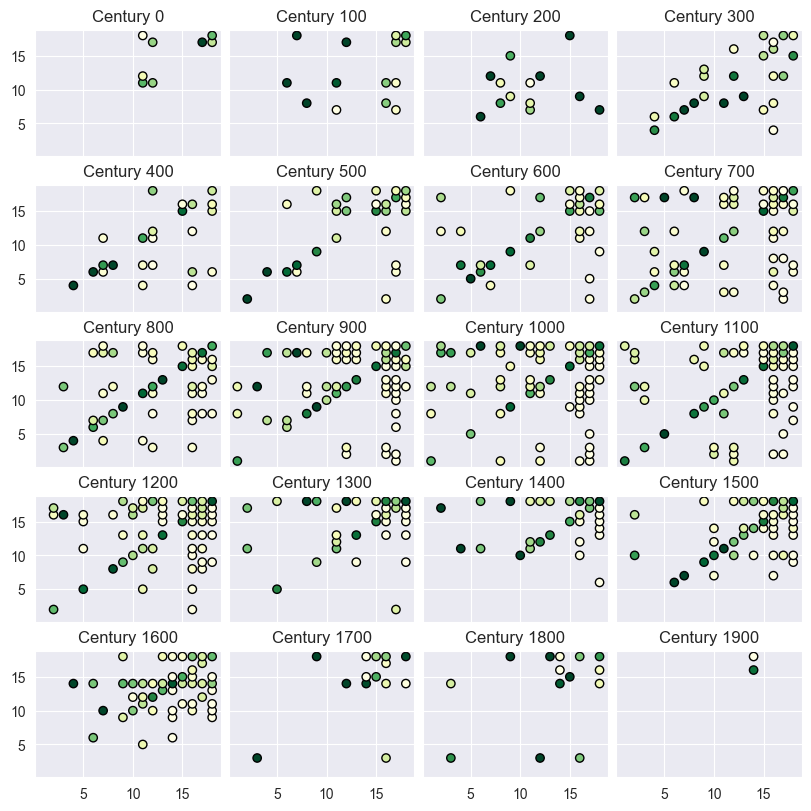

In [186]:
# compare parent's country vs child's country by century to see migration periods in history

fig, axs = plt.subplots(5, 4, sharex=True, sharey=True,figsize=(8, 8), layout="constrained")
subplotX = 0
subplotY = 0
for i, century in enumerate(BirthCentury_df['BirthCentury']):

    plot_df = p_v_c_v_t_ctry_df[(p_v_c_v_t_ctry_df['BirthCentury'] == century)].copy()
    color = plot_df['p_ctry_pct'] 
    axs[subplotX, subplotY].scatter(plot_df['country_code'], plot_df['C_country_code'],c=color, vmax=1, cmap="YlGn", edgecolors="k")
    #axs[subplotX, subplotY].scatter(plot_df['country_code'], plot_df['C_country_code'])
    axs[subplotX, subplotY].set_title("Century " + str(century))
    subplotY += 1
    if subplotY > 3: 
        subplotY = 0
        subplotX += 1

        
plt.show()        

In [189]:
# double check counts by country by time period

#p_v_c_v_t_ctry_df = pd.pivot_table(p_v_c_v_t_ctry_df, index=['country_code'], values=['BirthCentury'], aggfunc='count').reset_index()

p_v_c_v_t_ctry_mat = pd.crosstab(model_df['country_code'],model_df['BirthCentury'])
p_v_c_v_t_ctry_mat

BirthCentury,0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900
country_code,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,6,16,9,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,10,3,0,0,5,4,9,2,1,3,0,0,0,0
3,0,0,0,0,0,0,0,7,6,2,3,11,2,0,0,0,0,7,7,0
4,0,0,0,8,7,3,6,9,8,3,0,0,0,0,1,0,1,0,0,0
5,0,0,0,0,0,0,1,1,0,0,4,2,31,8,0,0,0,0,0,0
6,0,1,8,11,13,15,7,13,8,3,1,0,0,0,2,2,2,0,0,0
7,0,2,2,5,7,9,22,29,14,1,0,0,0,0,0,2,2,0,0,0
8,0,2,7,9,1,0,0,1,10,19,8,17,38,2,0,0,0,0,0,0
9,0,0,3,3,0,8,8,6,10,9,25,6,11,10,2,9,9,2,2,0


# Evaluation  <-  All of the CRISP-DM Steps are in this project

#  Deployment  <-  All of the CRISP-DM Steps are in this project

Results of this project are deployed at https://mtmssteffen.github.io/

The results of this project will be used as the starting point for follow on projects investigating ancestor migration patterns.
